# Imports packages and define some useful functions

### Packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import csv
import datetime as timedelta

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import average_precision_score

import lightgbm as lgbm
from lightgbm import LGBMClassifier

import optuna
#pip install --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host files.pythonhosted.org optuna
from optuna.integration import LightGBMPruningCallback

import shap

import pickle

C:\Users\17138\anaconda3\envs\Nate3_8\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User Defined Functions

In [2]:
def get_shape(df):
    """
 extract the shape of the dataframein form of a tuple (numberofrows, number of columns)
    """
    return df.shape
 

def count_duplicates(df, list_of_cols):
    '''
 Counts the number of duplicates in the dataframe
 If the list of columns (list_of_cols) is empty [], it will count the number of duplicates based on all columns
 If the list of columns (list_of_cols) is specified, it will cuntthe number of duplicates based on the specified columns
    '''
    if list_of_cols== []:
        return df.duplicated().sum()
    else:
        return df.duplicated(list_of_cols).sum()

 

def show_duplicates(df, list_of_cols):
    '''
 Shows the duplicated records
 If the list of columns (list_of_cols) is [], will show the duplicates based on all columns
 If the list of columns is specified, it will show the duplicates based on the specified columns
    '''
    if list_of_cols== []:
        duplicate_filter= df.duplicated(keep = False) # df.duplicated() is the filter
        return df[duplicate_filter]
    else:
        duplicate_filter= df.duplicated(list_of_cols, keep = False)
        return df[duplicate_filter].sort_values(list_of_cols[0])

 
def get_datatype(df):
    '''
 Extracts the data type of columns of the dataframedf
 Returns a dataframe(datatype) that summarizes data type for each column
    '''
    datatypes = pd.DataFrame(df.dtypes, columns =['DataType'])
    return datatypes
 

def get_cat_cols(df):
    '''
 Extracts a list of columns in datafraamdfwhose datatype is not numerical
    '''
    cat_cols= df.select_dtypes(exclude = 'number').columns.values.tolist()
    return cat_cols

 
def get_num_cols(df):
    '''
 Extract a list of columns in dataframedfwhose datatype is numerical
    '''
    num_cols= df.select_dtypes(include = 'number').columns.values.tolist()
    return num_cols


def count_missings(df):
    '''
 Calculates number of missing values, percentage of missing values for each column
 Returns a dataframesummarizing the results
    '''
    percent_missing= df.isnull().mean().round(2).mul(100)
    count_missing= df.isnull().sum()
    missing_value_df= pd.DataFrame({'column_name': df.columns, 
                                    'count_missing':count_missing,
                                    'percent_missing': percent_missing})
    return missing_value_df.sort_values('percent_missing')

In [3]:
def categories_dist(df, cat_cols_list, target_col):
    '''
 Plot distribution of categorical features in a dataframe
 df: dataframe
 cat_cols_list: list of categorical features
 target_col: the target varibleto count on
    '''
    for attr in cat_cols_list:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
        outcome_counts= df.groupby([attr, target_col]).size().rename('count').reset_index()
        by_outcome= outcome_counts.pivot(columns=target_col, values='count', index=attr)
         # Plot the proportions
        by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
        # Plot the counts
        df[attr].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
        print('Feature (%s)\n' % attr)
        print(df[attr].value_counts(), '\n')
        plt.title(attr)


def target_dist(df, target_col):
    '''
 Count the records of each category in the target column (target_col) in the dataframe(df) 
    '''
    return df[target_col].value_counts()
 

def box_plots(df, num_cols_list, fig_size):
    '''
 Creates boxplot for each numerical column in the dataframewith a specified figure size
 df: dataframe
 num_cols_list: list of numerical columns
 fig_size: figure size
    '''
    test_df= df[num_cols_list]
    inputs = list(test_df.columns) #convert the column names to a list

     # Determine the number of logging curves
    num_inputs= len(inputs)

    # Create a figure with num_inputsrow, and 1 long
    fig, axs= plt.subplots(num_inputs, 1, figsize=fig_size) #(5,40)

     # Use a for loop to loop over each column in the dataframeand 
     # createa separate box plot
    for i, (ax, curve) in enumerate(zip(axs.flat, inputs)):
        sns.boxplot(y=test_df[curve], ax=ax, color='cornflowerblue', showmeans=True,
                    meanprops={"marker":"o",
                               "markerfacecolor":"white", 
                               "markeredgecolor":"black",
                               "markersize":"10"},
                    flierprops={'marker':'o', 
                                'markerfacecolor':'darkgreen',
                                'markeredgecolor':'darkgreen'})


        ax.set_title(inputs[i])
        ax.set_ylabel('')

    plt.subplots_adjust(hspace=0.15, wspace=1.25)
    plt.show()
    del(test_df)

In [4]:
def extract_popular_items(df, list_of_crowded_cols, threshold):
    popular_items= {}
    for c in list_of_crowded_cols:
        value_counts= df[c].value_counts()
        popular_values= list(value_counts[value_counts>threshold].index)
        popular_items[c] = popular_values
    return popular_items


def nullify_rare_items(df, list_of_crowded_cols, lib_of_popular_items):
    for c in list_of_crowded_cols:
        df[c] = df[c].where(df[c].isin(lib_of_popular_items[c]), None)
    return df
 

def fillna_with_label(df, list_of_cols, label):
    for c in list_of_cols:
        df[c] = df[c].fillna(label, inplace= False)
    return df
 

def clean_up_state(df, state_col_name, state_list, state_dict):
    df= fillna_with_label(df, [state_col_name], 'Others')
    df[state_col_name] = df[state_col_name].str.upper()
    df[state_col_name] = df[state_col_name].where(df[state_col_name].isin(state_list),'Others')
    df[state_col_name] = df[state_col_name].replace(state_dict)
    return df


def get_boxplot_bounds(df, num_cols_list):
    '''
 Calculates the actual bounds of the box_plotfor each specified numerical feature
    '''
    bounds_dict= {}
    for numcol in num_cols_list:
        bounds = {}
        data = df[numcol]
        median = np.nanmedian(data)
        upper_quartile= np.nanpercentile(data, 75)
        lower_quartile= np.nanpercentile(data, 25)
        iqr= upper_quartile- lower_quartile
        upper_bound= data[data <= upper_quartile+1.5*iqr].max()
        lower_bound= data[data >= upper_quartile-1.5*iqr].min()
        bounds['upper_bound'] = upper_bound
        bounds['lower_bound'] = lower_bound
        bounds_dict[numcol] = bounds
    return bounds_dict

 

def get_medians_avg(df, num_cols_list):

    '''
 Calculates the actual bounds of the box_plotfor each specified numerical feature
    '''
    center_dict= {}
    for numcol in num_cols_list:
        centers = {}
        data = df[numcol]
        median = np.nanmedian(data)
        mean = np.nanmean(data)
        centers['mean'] = mean
        centers['median'] = median
        center_dict[numcol] = centers
    return center_dict

# Gets Data

In [5]:
path = os.getcwd()
csvs = glob.glob(os.path.join(path,'*.csv'))
csvs

['C:\\Users\\17138\\Downloads\\phdata-ds-project-challenge\\LGBM\\project_data.csv']

In [6]:
df = pd.read_csv('C:\\Users\\17138\\Downloads\\phdata-ds-project-challenge\\project_data.csv')

# EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              41188 non-null  int64  
 1   b1               41188 non-null  object 
 2   b2               40198 non-null  object 
 3   c10              41188 non-null  object 
 4   c3               41188 non-null  object 
 5   c4               41188 non-null  object 
 6   c8               5625 non-null   object 
 7   dow              41188 non-null  object 
 8   employment       41188 non-null  object 
 9   i1               41188 non-null  float64
 10  i2               41188 non-null  float64
 11  i3               41188 non-null  float64
 12  i4               41188 non-null  float64
 13  i5               41188 non-null  float64
 14  marriage-status  41108 non-null  object 
 15  month            41188 non-null  object 
 16  n2               41188 non-null  int64  
 17  n3          

In [8]:
df

,age,b1,b2,c10,c3,c4,c8,dow,employment,i1,...,i5,marriage-status,month,n2,n3,n4,n5,n6,school,successful_sell
0,34,yes,no,no,False,new,NaN,fri,management,-1.8,...,5099.1,divorced,apr,2,530,999,0.001771,0,5 - a decent amount,no
1,28,yes,no,yes,False,new,NaN,thu,assistant,-1.8,...,5099.1,divorced,may,1,750,999,-1.673152,0,5 - a lot,yes
2,55,no,no,no,unknown,new,NaN,tue,leisure,1.4,...,5228.1,married,jul,3,600,999,0.927946,0,2 - a little bit,no
3,47,yes,no,no,False,new,NaN,mon,assistant,-0.1,...,5195.8,married,nov,1,860,999,0.203013,0,5 - a lot,no
4,49,no,no,no,unknown,new,NaN,tue,assistant,1.4,...,5228.1,married,jul,6,620,999,0.990804,0,5 - a lot,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,33,yes,no,no,False,old,NaN,mon,assistant,1.4,...,5228.1,married,jun,3,620,999,-0.050022,0,4 - average amount,no
41184,36,yes,no,no,False,old,NaN,mon,engineer,1.4,...,5228.1,married,jun,1,650,999,-2.310504,0,5 - a lot,no
41185,36,no,no,no,False,new,NaN,mon,engineer,1.4,...,5228.1,divorced,jul,3,620,999,2.144238,0,5 - a decent amount,no
41186,50,no,no,no,False,old,NaN,fri,hobbyist,1.4,...,5228.1,married,jun,2,880,999,0.359144,0,1 - almost none,no


In [9]:
# Explore target distrinution
df['successful_sell'].value_counts()

no     36548
yes     4640
Name: successful_sell, dtype: int64

The above indicates inbalanced dataset. The modeling step will need to address this issue by either (1) assigning weights for each class or (2) sampling with SMOTE techniques or downsampling

In [10]:
# Changes the format of target variable with 'yes' to 1 and 'no' to 0
df['successful_sell'] = df.successful_sell.map(dict(yes=1, no =0))

In [11]:
df['successful_sell'].value_counts()

0    36548
1     4640
Name: successful_sell, dtype: int64

We've seen columns 'n4', 'c8' and 'school' have missing values. Let's look into them

In [12]:
df['n4'].value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
27         1
26         1
20         1
25         1
Name: n4, dtype: int64

The values above are numerics but given the number of unique values, they seem to be categorical. In addition, the value 999 seems to be the most crowding value in this column and may account for some particular behavior.. It may have some meaning. There are also values that is rather rare or accur at very low frequency. It's better to treat this column as a categorical one.

In [13]:
df['b2'].value_counts()

no     33950
yes     6248
Name: b2, dtype: int64

The amount of missing values in b2 is small. We can fill these missing with a third categorical 'Others'.

In [14]:
df['c8'].value_counts()

no     4252
yes    1373
Name: c8, dtype: int64

The column c8 misses a lot of values. We may want to look at the distribution os 'yes', 'no' and null to see if there is any signal related to the target.

In [15]:
df['school'].value_counts()

5 - a lot              12168
4 - average amount      9515
3 - a bit more          6045
5 - a decent amount     5243
1 - almost none         4176
2 - a little bit        2292
0 - none                  18
Name: school, dtype: int64

'school' has small amount of missing values. It also contains class with low frequency ('0-none')

In [16]:
#cheching for duplicates in the dataset
count_duplicates(df,[])

0

In [17]:
# summarize the percentage of missing values in the columns
count_missings(df)

,column_name,count_missing,percent_missing
age,age,0,0.0
n6,n6,0,0.0
n5,n5,0,0.0
n4,n4,0,0.0
n3,n3,0,0.0
n2,n2,0,0.0
month,month,0,0.0
marriage-status,marriage-status,80,0.0
i5,i5,0,0.0
i4,i4,0,0.0


We will have a list of categorical columns and a list of numerical columns. Then we can look at the statistics of two types

In [18]:
cat_cols = ['b1', 'b2', 'c3', 'c4', 'c8','c10', 'dow', 'employment','marriage-status', 'month','n4','n6','school']
#convert the categorical columns into string type
for cat in cat_cols:
    df =df.astype({cat:str})

num_cols = ['age','i1','i2', 'i3', 'i4', 'i5','n2', 'n3','n5']
# convert the numerical columns into float type
for num in num_cols:
    df = df.astype({num:float})

### Understanding Numerical Columns

In [19]:
#overall statistics
df[num_cols].describe()

,age,i1,i2,i3,i4,i5,n2,n3,n5
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,0.081886,93.575664,-40.502600,3.621291,5167.035911,2.567593,745.142032,-0.000074
std,10.42125,1.570960,0.578840,4.628198,1.734447,72.251528,2.770014,144.246196,0.997024
min,17.00000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,1.000000,500.000000,-4.354231
25%,32.00000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,1.000000,620.000000,-0.679725
50%,38.00000,1.100000,93.749000,-41.800000,4.857000,5191.000000,2.000000,750.000000,0.001357
75%,47.00000,1.400000,93.994000,-36.400000,4.961000,5228.100000,3.000000,870.000000,0.673380
max,98.00000,1.400000,94.767000,-26.900000,5.045000,5228.100000,56.000000,990.000000,4.547729


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'i1'}>,
        <AxesSubplot:title={'center':'i2'}>],
       [<AxesSubplot:title={'center':'i3'}>,
        <AxesSubplot:title={'center':'i4'}>,
        <AxesSubplot:title={'center':'i5'}>],
       [<AxesSubplot:title={'center':'n2'}>,
        <AxesSubplot:title={'center':'n3'}>,
        <AxesSubplot:title={'center':'n5'}>]], dtype=object)

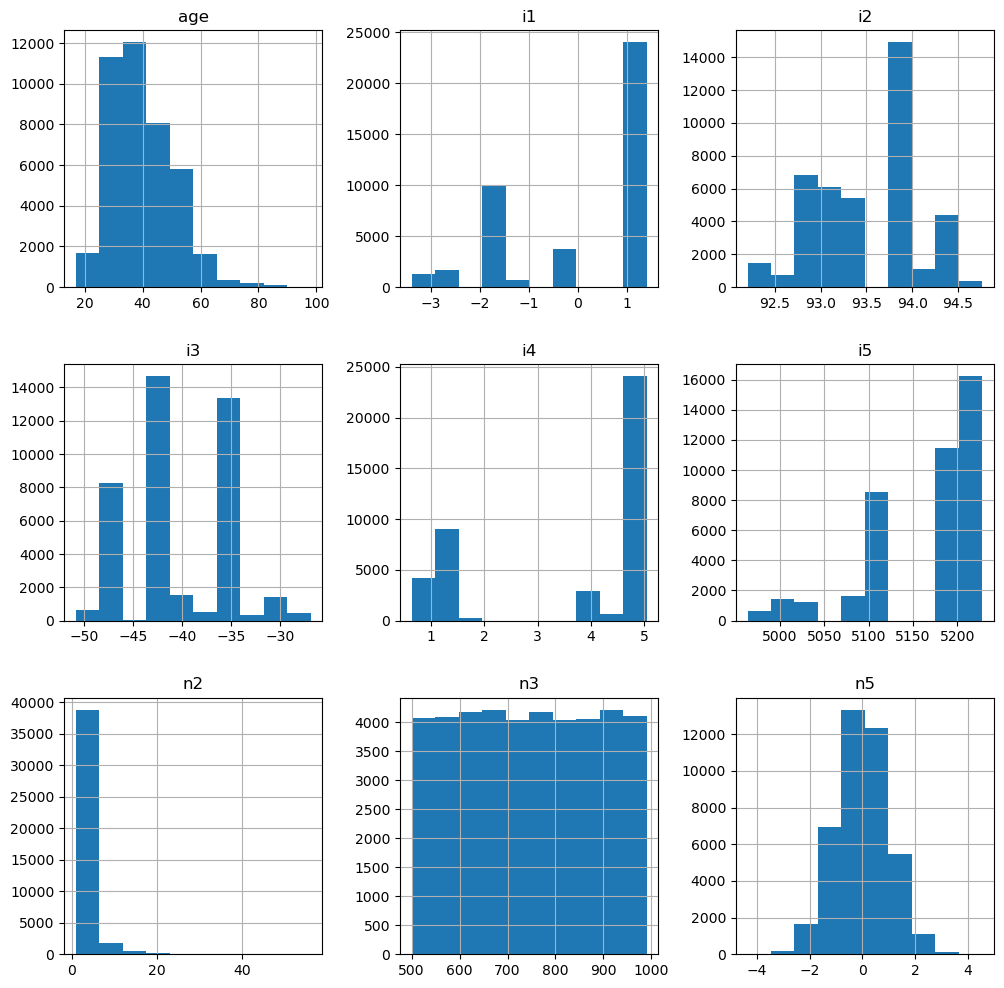

In [20]:
# plot histogram for each numerical column
df[num_cols].hist(figsize = (12,12))

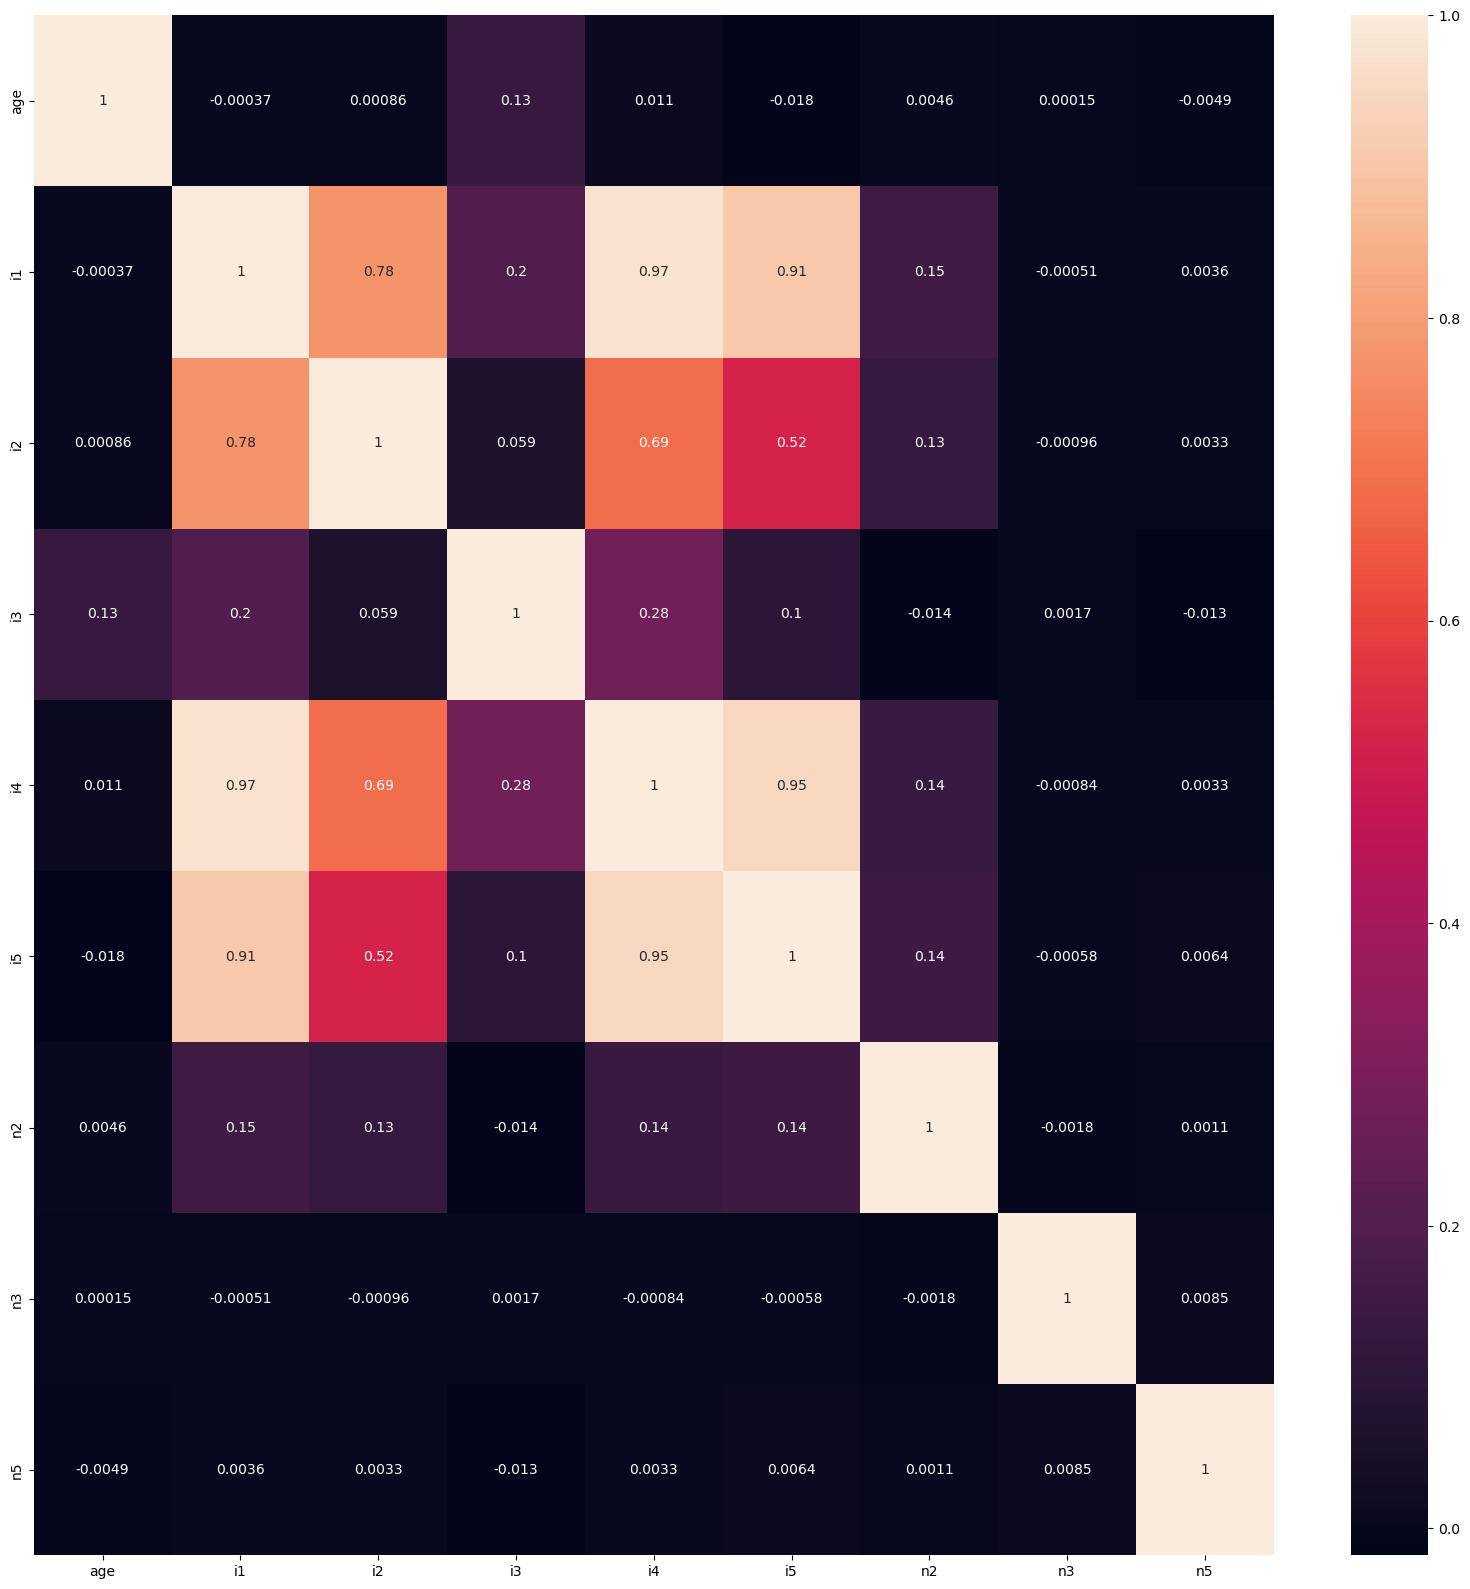

In [21]:
# Visualize correlation matrix to inspect correlation between the numerical columns
corrMatrix = df[num_cols].corr()
plt.figure(figsize = (20,20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

The above heatmap reveals high correlation between i1, i2, i4 and i5. Therefore we will keep only i1 for modeling. The updated list of numerical columns will be the below

In [22]:
num_cols = ['age','i1','i3','n2', 'n3','n5']

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

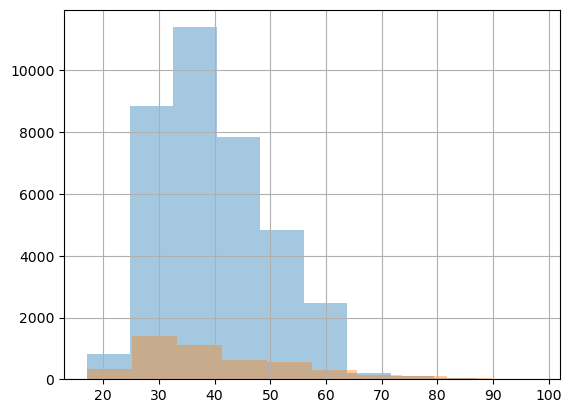

In [23]:
df.groupby("successful_sell").age.hist(alpha=0.4)

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: age, dtype: object

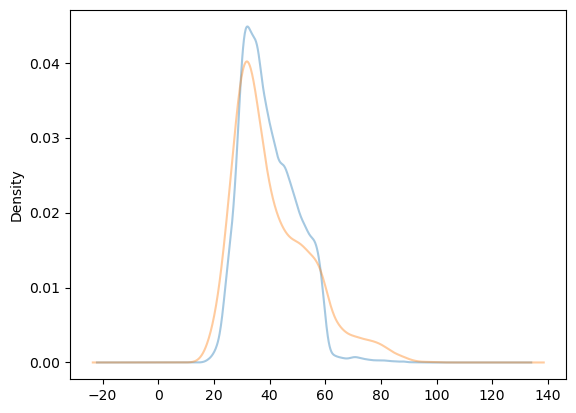

In [24]:
df.groupby("successful_sell").age.plot(alpha=0.4, kind = 'kde')

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: i1, dtype: object

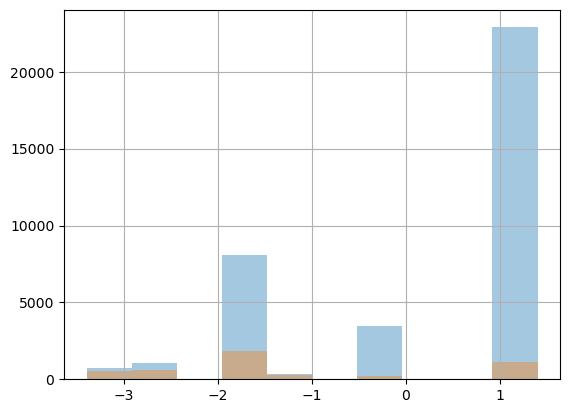

In [25]:
df.groupby("successful_sell").i1.hist(alpha=0.4)

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: i1, dtype: object

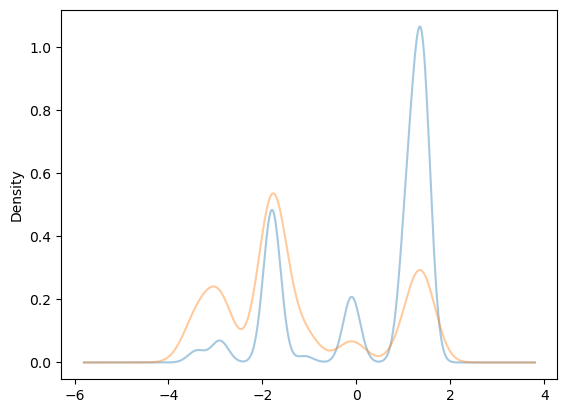

In [26]:
df.groupby("successful_sell").i1.plot(alpha=0.4, kind = 'kde')

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: i3, dtype: object

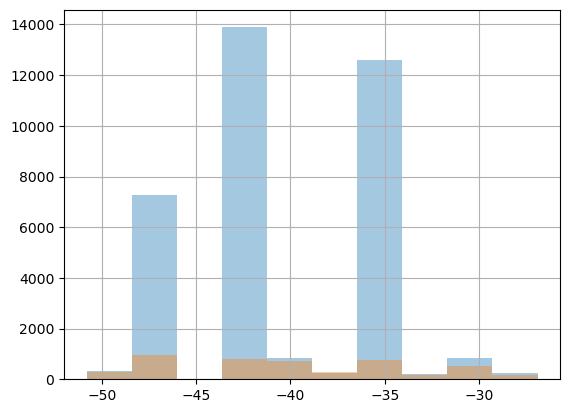

In [27]:
df.groupby("successful_sell").i3.hist(alpha=0.4)

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: i3, dtype: object

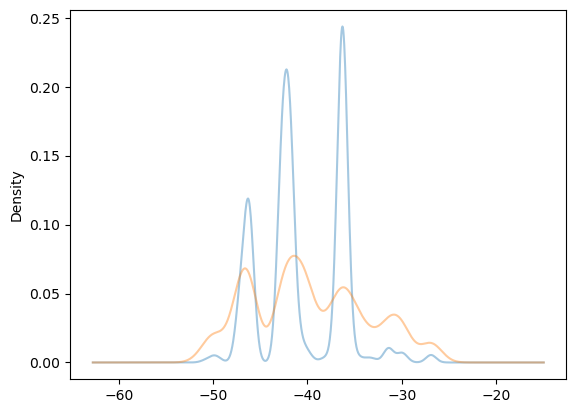

In [28]:
df.groupby("successful_sell").i3.plot(alpha=0.4, kind = 'kde')

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: n2, dtype: object

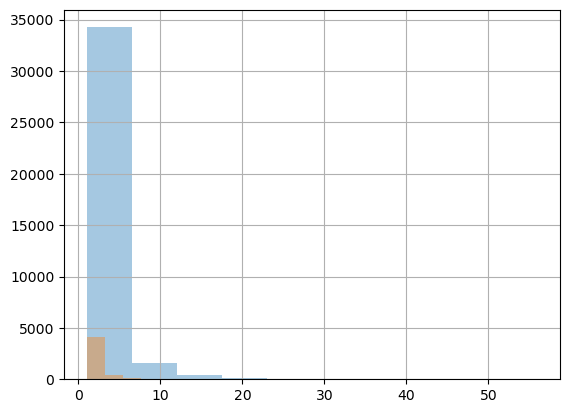

In [29]:
df.groupby("successful_sell").n2.hist(alpha=0.4)

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: n2, dtype: object

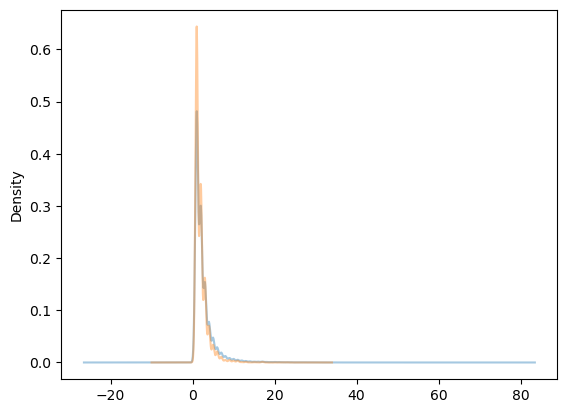

In [30]:
df.groupby("successful_sell").n2.plot(alpha=0.4, kind = 'kde')

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: n3, dtype: object

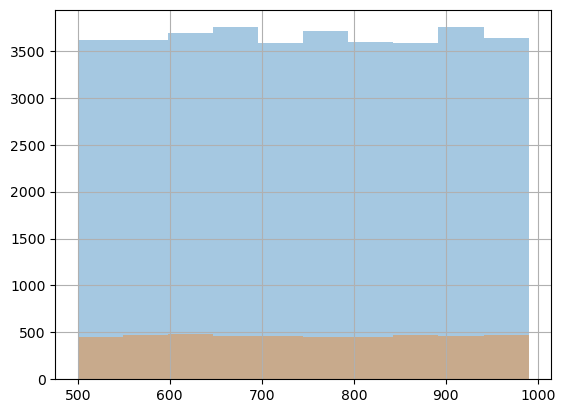

In [31]:
df.groupby("successful_sell").n3.hist(alpha=0.4)

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: n3, dtype: object

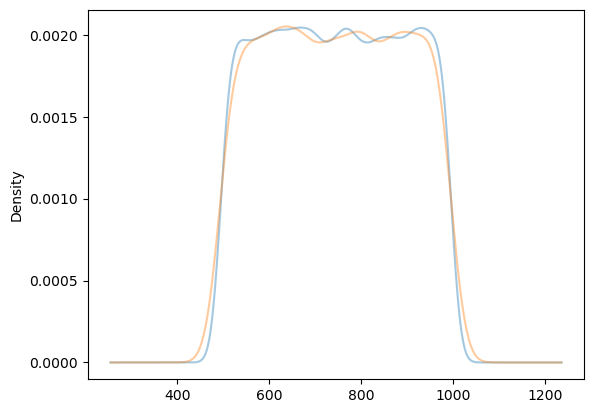

In [32]:
df.groupby("successful_sell").n3.plot(alpha=0.4, kind = 'kde')

successful_sell
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
Name: n5, dtype: object

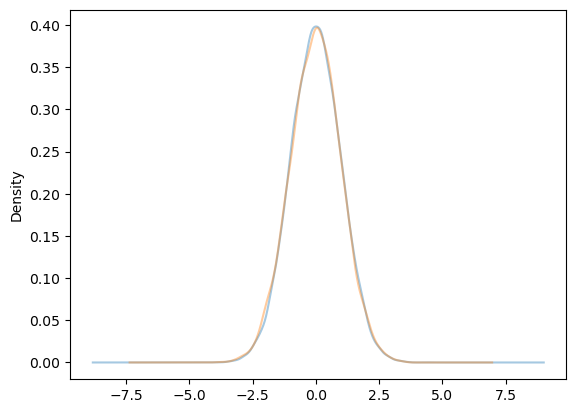

In [33]:
df.groupby("successful_sell").n5.plot(alpha=0.4, kind = 'kde')

### Understanding Categorical Columns

Feature (b1)

yes    21576
no     18622
-1       990
Name: b1, dtype: int64 

Feature (b2)

no     33950
yes     6248
nan      990
Name: b2, dtype: int64 

Feature (c3)

False      32588
unknown     8597
True           3
Name: c3, dtype: int64 

Feature (c4)

new    26144
old    15044
Name: c4, dtype: int64 

Feature (c8)

nan    35563
no      4252
yes     1373
Name: c8, dtype: int64 

Feature (c10)

no     36548
yes     4640
Name: c10, dtype: int64 

Feature (dow)

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: dow, dtype: int64 

Feature (employment)

assistant           10422
laborer              9254
engineer             6743
customer service     3969
management           2924
leisure              1720
hobbyist             1456
self-employed        1421
cleaner              1060
none                 1014
student               875
unknown               330
Name: employment, dtype: int64 

Feature (marriage-status)

married     24928
single      11568
divorced     

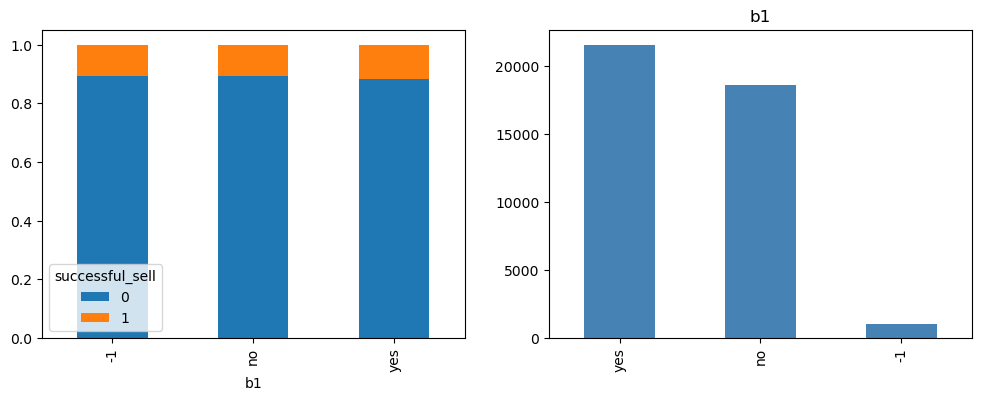

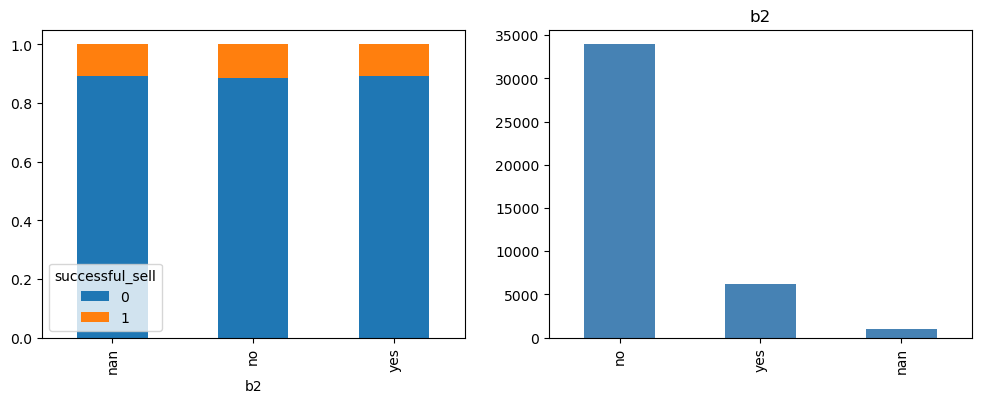

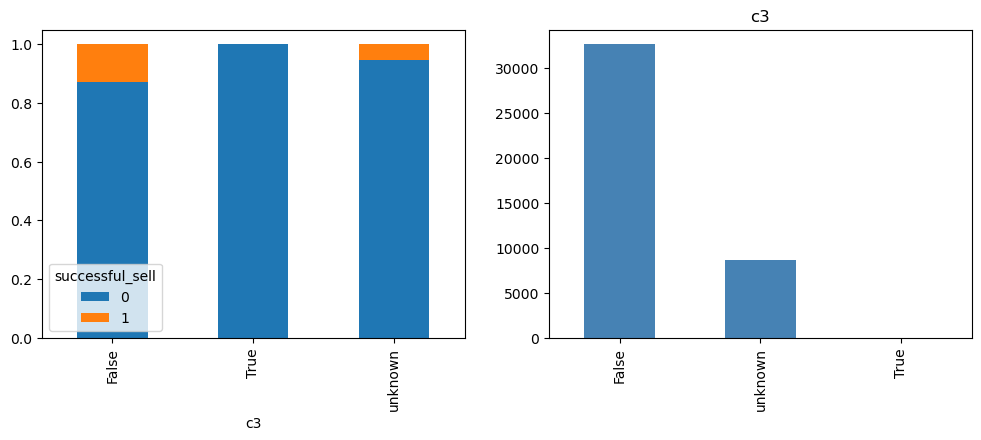

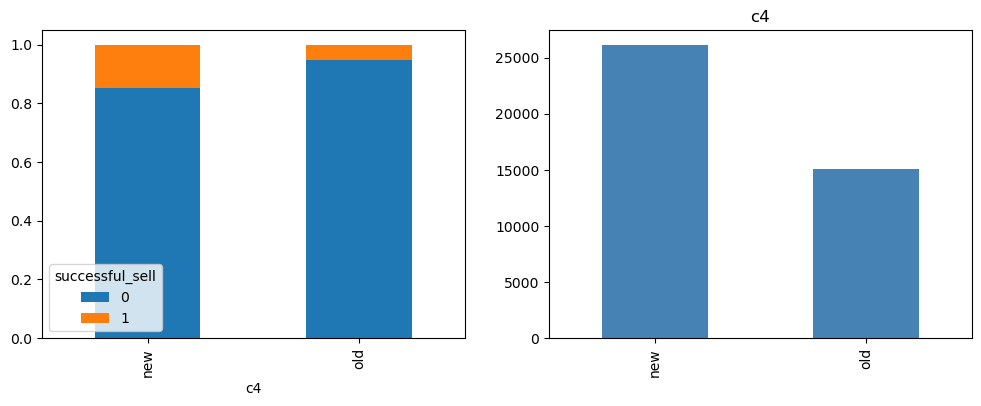

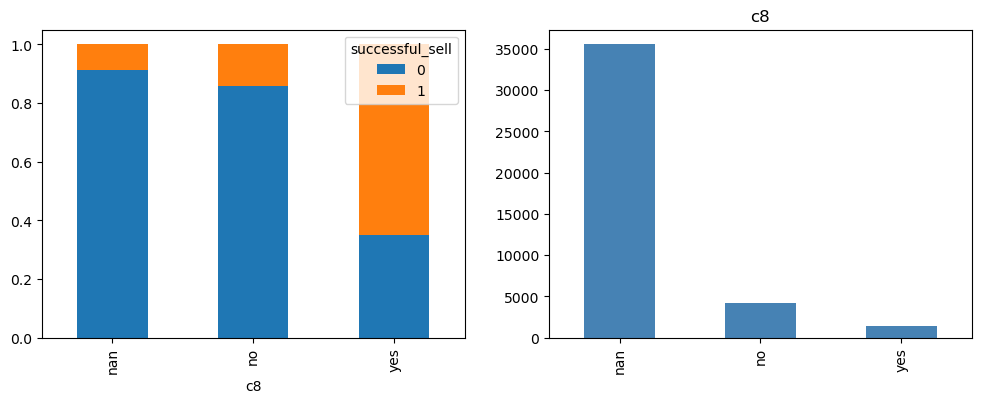

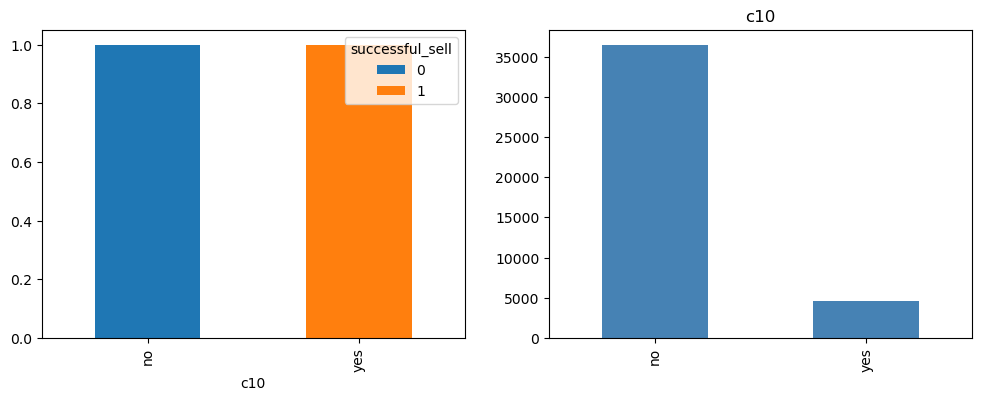

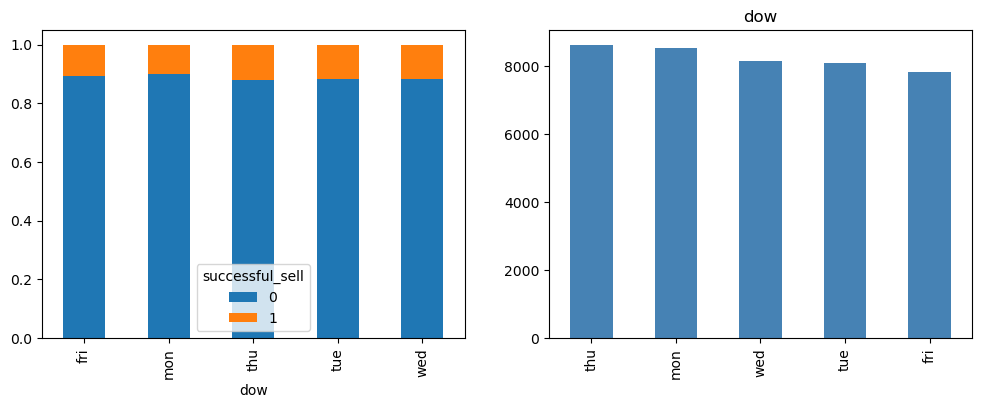

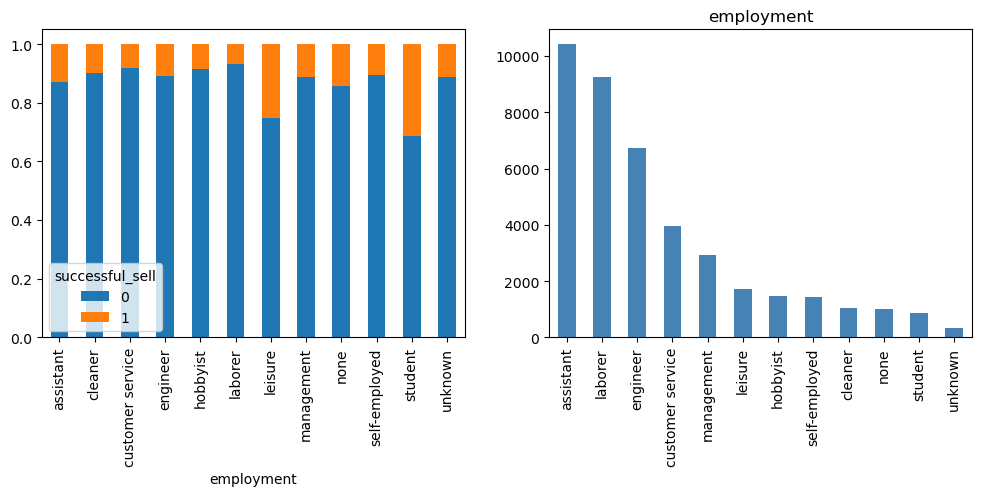

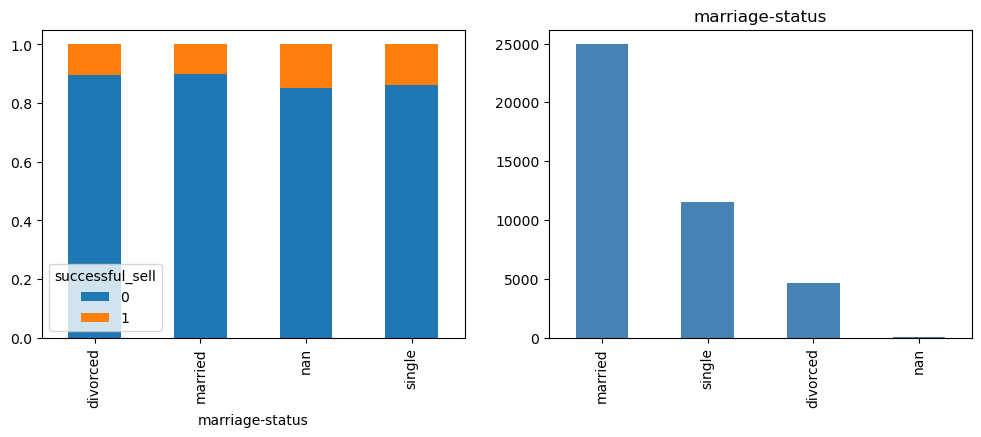

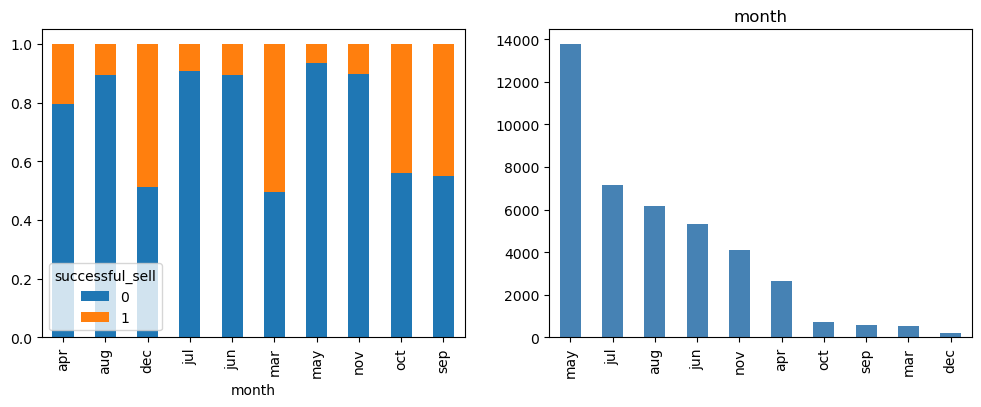

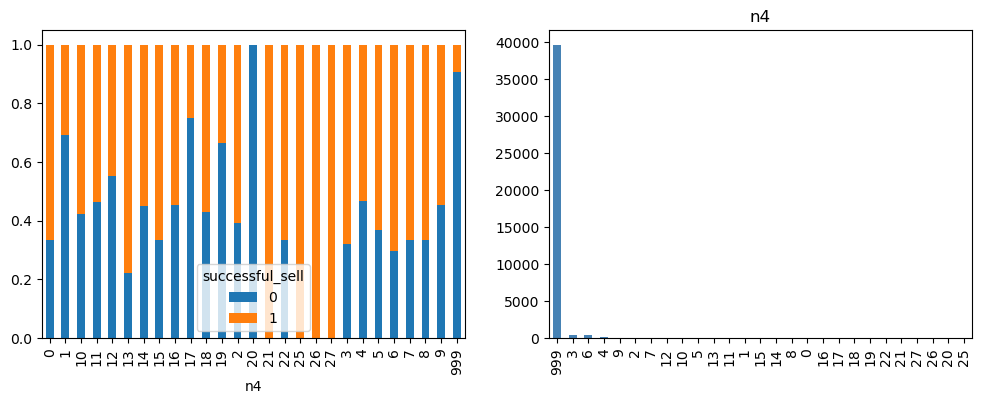

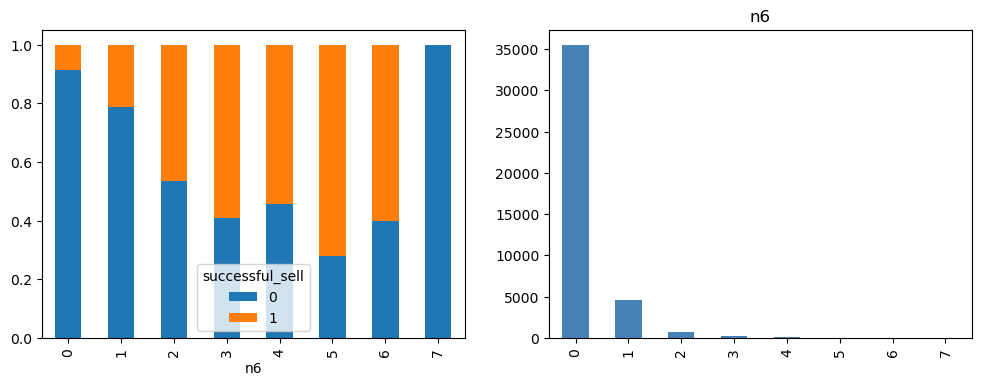

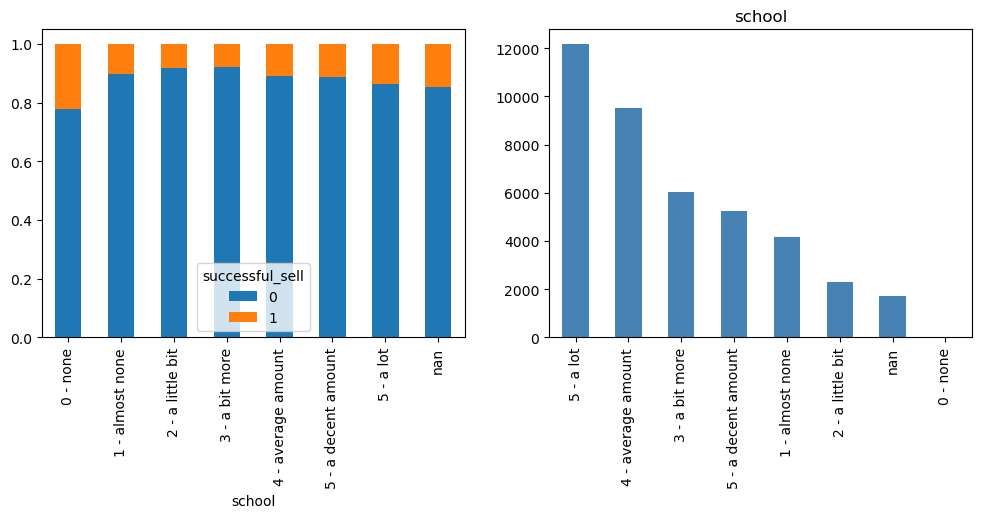

In [34]:
# Look at the distribution of the categories in relation to the target
categories_dist(df, cat_cols,'successful_sell' )

The above indicates column c10 is target leakage, we need to remove it. The updated list of categorical columns will be the below,

In [35]:
cat_cols = ['b1', 'b2', 'c3', 'c4', 'c8', 'dow', 'employment','marriage-status', 'month','n4','n6','school']

# Process Data

As mention above, there are columns with rare values. For any frequency below 30, we will convert them to null values. 
Then all null values in categorical columns will be filled with a new category 'Others'

In [36]:
# Identify columns with low frequency categories
crowded_cols = ['n4','n6','school']
# Store categories with high frequncy (above30) into a library
lib_of_popular_items = extract_popular_items(df, crowded_cols, 30)

# Convert low frequency value into nulls using user defined function
df = nullify_rare_items(df, crowded_cols, lib_of_popular_items)

# Fill null values in categorical values with new category 'Others'
df = fillna_with_label(df,cat_cols,'Others')

Numeric columns has two main issues to handle: outliers and missing values

In [37]:
# For numerical columns, we will handle outliers by clipping them to the boundary of the boxplot.
# To handle missing values, we will fill with median values

# Extract boundary value of boxplot using user-defined function
bound_dict = get_boxplot_bounds(df, num_cols)
# Extract mean and median of numerical columns using user-defined function
center_dict = get_medians_avg(df, num_cols)

for i in num_cols:
    # fill nulls with median
    df[i] = df[i].fillna(center_dict[i]['median'], inplace = False)
    # clip outliers with boundary values
    df[i] = df[i].clip(lower = bound_dict[i]['lower_bound'], upper = bound_dict[i]['upper_bound'])

#### To prep the data for modeling, we will 

(1) split the data

(2) encode categorical columns

(3) define weights for the classes in target column

In [38]:
# Define the dataframe of predictors
X = df[cat_cols + num_cols]
# Define target
y = df['successful_sell']

# Split into train and test with ratio of 80:20
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y, test_size = 0.2, random_state= 47)

In [39]:
X_train = X_train.append(pd.Series(), ignore_index = True)
X_train = fillna_with_label(X_train, cat_cols,'Others')

all_cats = {}
for v in cat_cols:
    item_list = list(X_train[v].values)
    all_cats[v] = item_list

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [40]:
# Create a library of indexers for the categorical columns
indexer_lib = {}
for c in cat_cols:
    indexer_lib[c] = preprocessing.LabelEncoder().fit(X_train[c])

In [41]:
# Encode the categorical columns with library of indexers
for f in cat_cols:
    X_train[f] = indexer_lib[f].transform(X_train[f])
    X_test[f] = indexer_lib[f].transform(X_test[f])

In [42]:
X_train = X_train[:-1]

# Define the categorical columns as categorical type
for col in cat_cols:
    X_train[col] = pd.Categorical(X_train[col])
    X_test[col] = pd.Categorical(X_test[col])

In [43]:
# We will need to know the distribution of each class in the target column to calculate the weights
y_train.value_counts()

0    29238
1     3712
Name: successful_sell, dtype: int64

In [44]:
# Occurence of class 0
n0 = len(y_train[y_train == 0])
# Occurence of class 1
n1 = len(y_train[y_train == 1])

# Calculate weight for each class
class_weight_0 = (n0+n1)/2/n0
class_weight_1 = (n0+n1)/2/n1

In [45]:
# extract cat. features' index
cat_idx = [X_train.columns.get_loc(col) for col in cat_cols]

# Modeling

We will run the LightGBM algorithm in this exercise. We didn't standardize the numerical features which would cause some impact to logistic regression and support-vector-machine. Therefore, tree-base algorithm would yield a better result in this situation.

We will tune the model to with corss-validation of 7 folds using Optuna as the tuning package.

In [46]:
'''
import time

N_SPLITS = 7
strat_kf= StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=47)

scores = np.empty(N_SPLITS)
for idx, (train_idx, val_idx) in enumerate(strat_kf.split(X_train,y_train)):
    print("="*12 + f"Trainingfold {idx}" + 12*"=")
    start = time.time()

    X_o, X_val= X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_o, y_val= y_train.iloc[train_idx], y_train.iloc[val_idx]
    eval_set= [(X_val,y_val)]

    model = lgbm.LGBMClassifier(objective="binary", class_weight= {0:class_weight_0, 1:class_weight_1})
    model.fit(
             X_o,
             y_o,
             eval_set=eval_set,
             categorical_feature=cat_idx,
             eval_metric='average_precision',
             early_stopping_rounds=100,
             verbose = False
              )
    
    preds_val= model.predict_proba(X_val)[:,1]
    predict_label_val= model.predict(X_val)
    auc= roc_auc_score(y_val, preds_val)
    pre = average_precision_score(y_val, predict_label_val)
    scores[idx] = pre
    runtime = time.time() - start
    print(f"LGBM Average-Precision with default cateogircalfeature handling: {pre:.5f} in {runtime:.2f} seconds.\n")
    
'''

'\nimport time\n\nN_SPLITS = 7\nstrat_kf= StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=47)\n\nscores = np.empty(N_SPLITS)\nfor idx, (train_idx, val_idx) in enumerate(strat_kf.split(X_train,y_train)):\n    print("="*12 + f"Trainingfold {idx}" + 12*"=")\n    start = time.time()\n\n    X_o, X_val= X_train.iloc[train_idx], X_train.iloc[val_idx]\n    y_o, y_val= y_train.iloc[train_idx], y_train.iloc[val_idx]\n    eval_set= [(X_val,y_val)]\n\n    model = lgbm.LGBMClassifier(objective="binary", class_weight= {0:class_weight_0, 1:class_weight_1})\n    model.fit(\n             X_o,\n             y_o,\n             eval_set=eval_set,\n             categorical_feature=cat_idx,\n             eval_metric=\'average_precision\',\n             early_stopping_rounds=100,\n             verbose = False\n              )\n    \n    preds_val= model.predict_proba(X_val)[:,1]\n    predict_label_val= model.predict(X_val)\n    auc= roc_auc_score(y_val, preds_val)\n    pre = average_precision_s

In [47]:
# import optuna#pip install optuna
# importlightgbmas lgbm
# fromlightgbmimport LGBMClassifier
# fromsklearn.metricsimport log_loss
# fromsklearn.model_selectionimport StratifiedKFold
# fromoptuna.integrationimport LightGBMPruningCallback
import time

def objective(trial, X_train, y_train):
    param_grid= {
 #"device_type": trial.suggest_categorical("device_type", ['gpu']),
         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
         "max_depth": trial.suggest_int("max_depth", 3, 12),
         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
         "max_bin": trial.suggest_int("max_bin", 200, 300),
         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
         "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
                 }

    N_SPLITS = 7
    strat_kf= StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=47)

    scores = np.empty(N_SPLITS)
    for idx, (train_idx, val_idx) in enumerate(strat_kf.split(X_train,y_train)):
        print("="*12 + f"Trainingfold {idx}" + 12*"=")
        start = time.time()

        X_o, X_val= X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_o, y_val= y_train.iloc[train_idx], y_train.iloc[val_idx]
        eval_set= [(X_val,y_val)]

        model = lgbm.LGBMClassifier(objective="binary", class_weight= {0:class_weight_0, 1:class_weight_1}, **param_grid)
        model.fit(
                X_o,
                y_o,
                eval_set=eval_set,
                categorical_feature=cat_idx,
                eval_metric='auc',
                early_stopping_rounds=100,
                verbose = False,
                callbacks=[LightGBMPruningCallback(trial, 'auc')]
                    )

        preds_val= model.predict_proba(X_val)[:,1]
        predict_label_val= model.predict(X_val)
        auc= roc_auc_score(y_val, preds_val)
        pre = average_precision_score(y_val, predict_label_val)
        scores[idx] = auc
    
    return np.mean(scores)

In [48]:
study = optuna.create_study(direction = "maximize", study_name="LGBM Classifier")
func = lambda trial:objective(trial, X_train, y_train)
study.optimize(func, n_trials =20)

[I 2022-11-07 21:57:00,756] A new study created in memory with name: LGBM Classifier
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=12.730975671972535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.730975671972535
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.2, colsampl

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=12.730975671972535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.730975671972535
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.


============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=12.730975671972535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.730975671972535
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.


============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=12.730975671972535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.730975671972535
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=12.730975671972535, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.730975671972535
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 5============


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 6============


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=8900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8900
[LightGBM] [Warning] min_gain_to_split is set=6.575633415347007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.575633415347007
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=40, reg_lambda=0.0 will be ignored. Current value: lambda_l2=40
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 0============


The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported va

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] min_gain_to_split is set=5.745292791657725, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.745292791657725
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Cu

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `ste

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ignored because this `step` 120 is already reported.
The reported value is ignored because this `step` 121 is already reported.
The reported value is ign

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ign

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because 

The reported value is ignored because this `step` 164 is already reported.
The reported value is ignored because this `step` 165 is already reported.
The reported value is ignored because this `step` 166 is already reported.
The reported value is ignored because this `step` 167 is already reported.
The reported value is ignored because this `step` 168 is already reported.
The reported value is ignored because this `step` 169 is already reported.
The reported value is ignored because this `step` 170 is already reported.
The reported value is ignored because this `step` 171 is already reported.
The reported value is ignored because this `step` 172 is already reported.
The reported value is ignored because this `step` 173 is already reported.
The reported value is ignored because this `step` 174 is already reported.
The reported value is ignored because this `step` 175 is already reported.
The reported value is ignored because this `step` 176 is already reported.
The reported value is ign

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] min_gain_to_split is set=14.602174034023097, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.602174034023097
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because 

The reported value is ignored because this `step` 196 is already reported.
The reported value is ignored because this `step` 197 is already reported.
The reported value is ignored because this `step` 198 is already reported.
The reported value is ignored because this `step` 199 is already reported.
The reported value is ignored because this `step` 200 is already reported.
The reported value is ignored because this `step` 201 is already reported.
The reported value is ignored because this `step` 202 is already reported.
The reported value is ignored because this `step` 203 is already reported.
The reported value is ignored because this `step` 204 is already reported.
The reported value is ignored because this `step` 205 is already reported.
The reported value is ignored because this `step` 206 is already reported.
[I 2022-11-07 21:57:07,684] Trial 3 finished with value: 0.7781395547644646 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2770142629538042, 'num_leaves': 2380, 'm

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.063803394527633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063803394527633
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Curr

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.063803394527633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063803394527633
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 3============


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.063803394527633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063803394527633
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightG

Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.063803394527633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063803394527633
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 6============


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_data_in_leaf is set=6800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6800
[LightGBM] [Warning] min_gain_to_split is set=4.063803394527633, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.063803394527633
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.5, colsampl

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because this `step` 41 is already reported.
The reported value is ignored because this `step` 42 is already reported.
The reported value is ignored because this `step` 43 is already reported.
The reported value is ignored because 

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because 

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=6700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6700
[LightGBM] [Warning] min_gain_to_split is set=11.331512691640766, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.331512691640766
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.128180464465507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.128180464465507
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Curr

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.128180464465507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.128180464465507
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because this `step` 40 is already reported.
The reported value is ignored because 

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.128180464465507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.128180464465507
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.128180464465507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.128180464465507
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=2900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2900
[LightGBM] [Warning] min_gain_to_split is set=6.128180464465507, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.128180464465507
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because 

============Trainingfold 0============
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because this `step` 37 is already reported.
The reported value is ignored because this `step` 38 is already reported.
The reported value is ignored because this `step` 39 is already reported.
The reported value is ignored because 

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=7000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7000
[LightGBM] [Warning] min_gain_to_split is set=3.0980234510084688, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.0980234510084688
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.5, colsampl

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because 

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=9500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9500
[LightGBM] [Warning] min_gain_to_split is set=2.8087417462758197, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.8087417462758197
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because this `step` 25 is already reported.
The reported value is ignored because this `step` 26 is already reported.
The reported value is ignored because this `step` 27 is already reported.
The reported value is ignored because this `step` 28 is already reported.
The reported value is ignored because this `step` 29 is already reported.
The reported value is ignored because this `step` 30 is already reported.
The reported value is ignored because this `step` 31 is already reported.
The reported value is ignored because this `step` 32 is already reported.
The reported value is ignored because this `step` 33 is already reported.
The reported value is ignored because this `step` 34 is already reported.
The reported value is ignored because this `step` 35 is already reported.
The reported value is ignored because this `step` 36 is already reported.
The reported value is ignored because 

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200
[LightGBM] [Warning] min_gain_to_split is set=4.891023176926432, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.891023176926432
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=10, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 21:57:18,301] Trial 9 pruned. Trial was pruned at iteration 181.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ignored because this `step` 120 is already reported.
The reported value is ignored because this `step` 121 is already reported.
The reported value is ignored because this `step` 122 is already reported.
The reported value is ignored because this `step` 123 is already reported.
The reported value is ignored because this `step` 124 is already reported.
The reported value is ign

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 173 is already reported.
The reported value is ignored because this `step` 174 is already reported.
The reported value is ignored because this `step` 175 is already reported.
The reported value is ignored because this `step` 176 is already reported.
The reported value is ignored because this `step` 177 is already reported.
The reported value is ignored because this `step` 178 is already reported.
The reported value is ignored because this `step` 179 is already reported.
The reported value is ignored because this `step` 180 is already reported.
The reported value is ignored because this `step` 181 is already reported.
The reported value is ignored because this `step` 182 is already reported.
The reported value is ignored because this `step` 183 is already reported.
The reported value is ignored because this `step` 184 is already reported.
The reported value is ignored because this `step` 185 is already reported.
The reported value is ign

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `

The reported value is ignored because this `step` 158 is already reported.
The reported value is ignored because this `step` 159 is already reported.
The reported value is ignored because this `step` 160 is already reported.
The reported value is ignored because this `step` 161 is already reported.
The reported value is ignored because this `step` 162 is already reported.
The reported value is ignored because this `step` 163 is already reported.
The reported value is ignored because this `step` 164 is already reported.
The reported value is ignored because this `step` 165 is already reported.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridd

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


The reported value is ignored because this `step` 12 is already reported.
The reported value is ignored because this `step` 13 is already reported.
The reported value is ignored because this `step` 14 is already reported.
The reported value is ignored because this `step` 15 is already reported.
The reported value is ignored because this `step` 16 is already reported.
The reported value is ignored because this `step` 17 is already reported.
The reported value is ignored because this `step` 18 is already reported.
The reported value is ignored because this `step` 19 is already reported.
The reported value is ignored because this `step` 20 is already reported.
The reported value is ignored because this `step` 21 is already reported.
The reported value is ignored because this `step` 22 is already reported.
The reported value is ignored because this `step` 23 is already reported.
The reported value is ignored because this `step` 24 is already reported.
The reported value is ignored because 

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=10.093884134623345, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.093884134623345
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

The reported value is ignored because this `step` 136 is already reported.
[I 2022-11-07 21:57:22,507] Trial 10 finished with value: 0.7907248801748212 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2905652250490454, 'num_leaves': 1800, 'max_depth': 7, 'min_data_in_leaf': 200, 'max_bin': 280, 'lambda_l1': 50, 'lambda_l2': 100, 'min_gain_to_split': 10.093884134623345, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.7907248801748212.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categ

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=14.766793248083232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.766793248083232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Cu

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_gain_to_split is set=14.766793248083232, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.766793248083232
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=50, reg_alpha=0.0 will be ignored. Current value: lambda_l1=50
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 122 is already reported.
The reported value is ignored because this `step` 123 is already reported.
The reported value is ignored because this `step` 124 is already reported.
The reported value is ignored because this `step` 125 is already reported.
The reported value is ignored because this `step` 126 is already reported.
The reported value is ignored because this `step` 127 is already reported.
The reported value is ignored because this `step` 128 is already reported.
The reported value is ignored because this `step` 129 is already reported.
The reported value is ignored because this `step` 130 is already reported.
[I 2022-11-07 21:57:24,079] Trial 11 pruned. Trial was pruned at iteration 189.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'ear

============Trainingfold 0============
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 127 is already reported.
The reported value is ignored because this `step` 128 is already reported.
The reported value is ignored because this `step` 129 is already reported.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=9.977604436497925, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.977604436497925
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ignored because this `step` 117 is already reported.
The reported value is ignored because this `step` 118 is already reported.
The reported value is ignored because this `step` 119 is already reported.
The reported value is ign

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_gain_to_split is set=9.198748955031187, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.198748955031187
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 21:57:28,249] Trial 13 pruned. Trial was pruned at iteration 101.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============


[I 2022-11-07 21:57:28,733] Trial 14 pruned. Trial was pruned at iteration 101.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============
============Trainingfold 1============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 2============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

============Trainingfold 3============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

The reported value is ignored because this `step` 136 is already reported.
The reported value is ignored because this `step` 137 is already reported.
The reported value is ignored because this `step` 138 is already reported.
The reported value is ignored because this `step` 139 is already reported.
The reported value is ignored because this `step` 140 is already reported.
The reported value is ignored because this `step` 141 is already reported.
The reported value is ignored because this `step` 142 is already reported.
The reported value is ignored because this `step` 143 is already reported.
The reported value is ignored because this `step` 144 is already reported.
The reported value is ignored because this `step` 145 is already reported.
The reported value is ignored because this `step` 146 is already reported.
The reported value is ignored because this `step` 147 is already reported.
The reported value is ignored because this `step` 148 is already reported.
The reported value is ign

============Trainingfold 4============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 119 is already reported.
The reported value is ignored because this `step` 120 is already reported.
The reported value is ignored because this `step` 121 is already reported.
The reported value is ignored because this `step` 122 is already reported.
The reported value is ignored because this `step` 123 is already reported.
The reported value is ignored because this `step` 124 is already reported.
The reported value is ignored because this `step` 125 is already reported.
The reported value is ignored because this `step` 126 is already reported.
The reported value is ignored because this `step` 127 is already reported.
The reported value is ignored because this `step` 128 is already reported.
The reported value is ignored because this `step` 129 is already reported.
The reported value is ignored because this `step` 130 is already reported.
The reported value is ignored because this `step` 131 is already reported.
The reported value is ign

============Trainingfold 5============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already repo

The reported value is ignored because this `step` 104 is already reported.
The reported value is ignored because this `step` 105 is already reported.
The reported value is ignored because this `step` 106 is already reported.
The reported value is ignored because this `step` 107 is already reported.
The reported value is ignored because this `step` 108 is already reported.
The reported value is ignored because this `step` 109 is already reported.
The reported value is ignored because this `step` 110 is already reported.
The reported value is ignored because this `step` 111 is already reported.
The reported value is ignored because this `step` 112 is already reported.
The reported value is ignored because this `step` 113 is already reported.
The reported value is ignored because this `step` 114 is already reported.
The reported value is ignored because this `step` 115 is already reported.
The reported value is ignored because this `step` 116 is already reported.
The reported value is ign

============Trainingfold 6============
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=1900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1900
[LightGBM] [Warning] min_gain_to_split is set=0.5841759521906731, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5841759521906731
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
The reported value is ignored because this `step` 0 is already reported.
The reported value is ignored because this `step` 1 is already reported.
The reported value is ignored because this `step` 2 is already reported.
The reported value is ignored because this `step` 3 is already reported.
The reported value is ignored because this `step` 4 is already reported.
The reported value is ignored because this `step` 5 is already reported.
The reported value is ignored because this `step` 6 is already reported.
The reported value is ignored because this `step` 7 is already reported.
The reported value is ignored because this `step` 8 is already reported.
The reported value is ignored because this `step` 9 is already reported.
The reported value is ignored because this `step` 10 is already reported.
The reported value is ignored because this `step` 11 is already reported.
The reported value is ig

[I 2022-11-07 21:57:33,684] Trial 15 finished with value: 0.7907185923084871 and parameters: {'n_estimators': 10000, 'learning_rate': 0.24321822606770743, 'num_leaves': 1760, 'max_depth': 9, 'min_data_in_leaf': 1900, 'max_bin': 279, 'lambda_l1': 65, 'lambda_l2': 0, 'min_gain_to_split': 0.5841759521906731, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.7907248801748212.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 

============Trainingfold 0============
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_gain_to_split is set=0.14269508152754357, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.14269508152754357
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2022-11-07 21:57:34,126] Trial 16 pruned. Trial was pruned at iteration 101.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============


[I 2022-11-07 21:57:34,544] Trial 17 pruned. Trial was pruned at iteration 101.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============


[I 2022-11-07 21:57:34,892] Trial 18 pruned. Trial was pruned at iteration 101.
The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
Using categorical_feature in Dataset.
categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


============Trainingfold 0============


[I 2022-11-07 21:57:35,282] Trial 19 pruned. Trial was pruned at iteration 101.


In [49]:
print(f"\tBest value AUC: {study.best_value:.5f}")
print(f"\Best params:")

for key,value in study.best_params.items():
    print(f"\t\t{key}:{value}")

	Best value AUC: 0.79072
\Best params:
		n_estimators:10000
		learning_rate:0.2905652250490454
		num_leaves:1800
		max_depth:7
		min_data_in_leaf:200
		max_bin:280
		lambda_l1:50
		lambda_l2:100
		min_gain_to_split:10.093884134623345
		bagging_fraction:0.9
		bagging_freq:1
		feature_fraction:0.4


In [50]:
# Extract the tuned parameters
tuned_params = study.best_params

In [51]:
# Train the model with the tuned params 
model = lgbm.LGBMClassifier(objective = "binary", class_weight= {0:class_weight_0, 1:class_weight_1}, **tuned_params)
model.fit(X_train,
          y_train,
          eval_set = [(X_test,y_test)],
          eval_metric = 'auc',
          early_stopping_rounds = 100)

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[1]	valid_0's average_precision: 0.305782	valid_0's binary_logloss: 0.652498
[2]	valid_0's average_precision: 0.402169	valid_0's binary_logloss: 0.605694
[3]	valid_0's average_precision: 0.418899	valid_0's binary_logloss: 0.578712
[4]	valid_0's average_precision: 0.423256	valid_0's binary_logloss: 0.562729
[5]	valid_0's average_precision: 0.424733	valid_0's binary_logloss: 0.553305
[6]	valid_0's average_precision: 0.427053	valid_0's binary_logloss: 0.54451
[7]	valid_0's average_precision: 0.433707	valid_0's binary_logloss: 0.538132
[8]	valid_0's average_precision: 0.43672	valid_0's binary_logloss: 0.537309
[9]	valid_0's average_precision: 0.434142	valid_0's binary_logloss: 0.537414
[10]	valid_0's average_precision: 0.428568	valid_0's binary_logloss: 0.532625
[11]	valid_0's average_precision: 0.429939	valid_0's binary_logloss: 0.53114
[12]	valid_0's average_precision: 0.429448	valid_0's binary_logloss: 0.528844
[13]	valid_0's average_precision: 0.429899	valid_0's binary_logloss: 0.52982

[164]	valid_0's average_precision: 0.445302	valid_0's binary_logloss: 0.520488
[165]	valid_0's average_precision: 0.445302	valid_0's binary_logloss: 0.520488
[166]	valid_0's average_precision: 0.445302	valid_0's binary_logloss: 0.520488
[167]	valid_0's average_precision: 0.445302	valid_0's binary_logloss: 0.520488
[168]	valid_0's average_precision: 0.445302	valid_0's binary_logloss: 0.520488


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1,
               class_weight={0: 0.5634790341336616, 1: 4.438308189655173},
               feature_fraction=0.4, lambda_l1=50, lambda_l2=100,
               learning_rate=0.2905652250490454, max_bin=280, max_depth=7,
               min_data_in_leaf=200, min_gain_to_split=10.093884134623345,
               n_estimators=10000, num_leaves=1800, objective='binary')

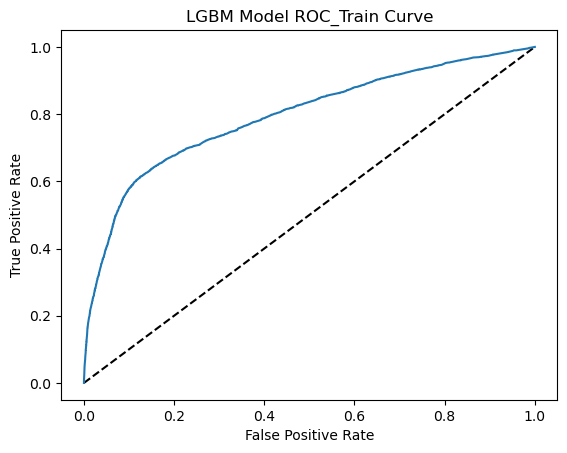

In [52]:
# ROC Curve of the trainset

preds_train = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, preds_train)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = "LGBM Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM Model ROC_Train Curve')
plt.show();

In [53]:
# Calculate AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, preds_train)

0.7945662914537882

<AxesSubplot:>

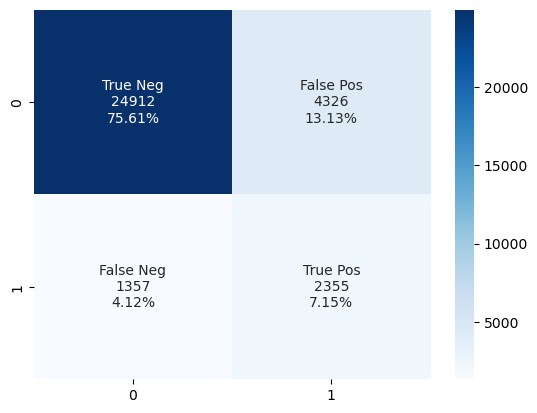

In [54]:
# Plot confusion matrix
predicted_label_train = model.predict(X_train)
train_matrix_base = confusion_matrix(y_train, predicted_label_train)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in train_matrix_base.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in train_matrix_base.flatten()/np.sum(train_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(train_matrix_base, annot = labels, fmt = '', cmap = 'Blues')

In [55]:
# We will devide the predicted probability into 10 buckets with bucket B1 containing users with the least least likelihood
# to convert. Bucket B10 will contain user with the best likelihood to convert

prediction_tb_train = pd.DataFrame(y_train, columns = ["successful_sell"])
prediction_tb_train["predicted_label"] = predicted_label_train
prediction_tb_train["predicted_proba"] = preds_train
prediction_tb_train["bucket"] = pd.qcut(x = preds_train, q =10, labels =[1,2,3,4,5,6,7,8,9,10])

results, bin_edges = pd.qcut(x = preds_train, q =10, labels =[1,2,3,4,5,6,7,8,9,10], retbins = True)
bin_table = pd.DataFrame(zip(bin_edges, [1,2,3,4,5,6,7,8,9,10]), columns = ['Threshold', 'Tier'])

bucket_tb_train = prediction_tb_train.groupby('bucket', as_index = False)\
                    .agg(volume = ("successful_sell", "count"), sell_rate = ("successful_sell","mean"),
                         BucketMax = ("predicted_proba","max"), BucketMin = ("predicted_proba","min"))

In [56]:
# Extract max probability of each bucket

threshold = list(bucket_tb_train['BucketMax'])
threshold.append(0)
threshold.sort()
threshold

[0,
 0.2091403163434279,
 0.23563734418665896,
 0.2788028676069921,
 0.30544871174902977,
 0.33088242247033606,
 0.3594401073615628,
 0.405514493449349,
 0.5052612722191105,
 0.773209283340306,
 0.9451955250772187]

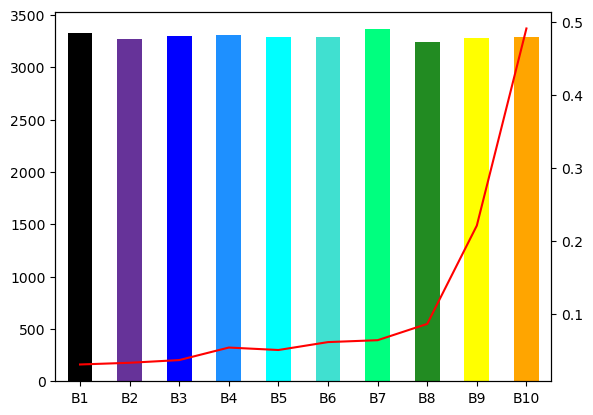

In [57]:
# Using the bucket, we can construct a lift chart!

colors=['black','rebeccapurple','blue','dodgerblue','cyan','turquoise','springgreen','forestgreen','yellow','orange']
bucket_tb_train['volume'].plot(kind='bar', color = colors)
bucket_tb_train['sell_rate'].plot(secondary_y=True, color = 'r')
ax = plt.gca()
ax.set_xticklabels(('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10'))
plt.show()

The lift chart indicate that our model has been trained properly. It predicts a low conversion rates at low buckets and high conversion rates at high buckets.


#### Let's look at test data

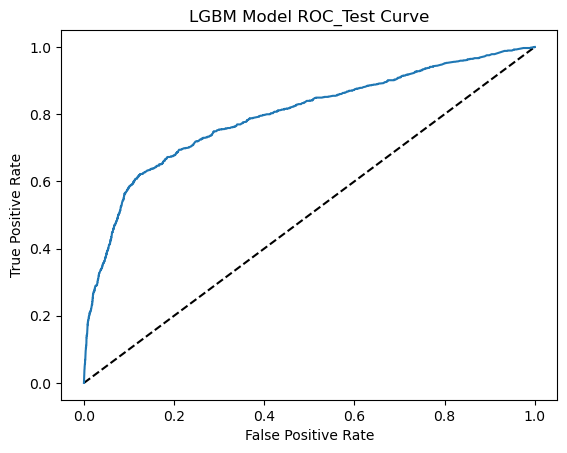

In [58]:
# ROC Curve of test data

preds_test = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds_test)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr, label = "LGBM Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGBM Model ROC_Test Curve')
plt.show();

In [59]:
# Area under ROC curve of test data

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, preds_test)

0.7950871798198028

<AxesSubplot:>

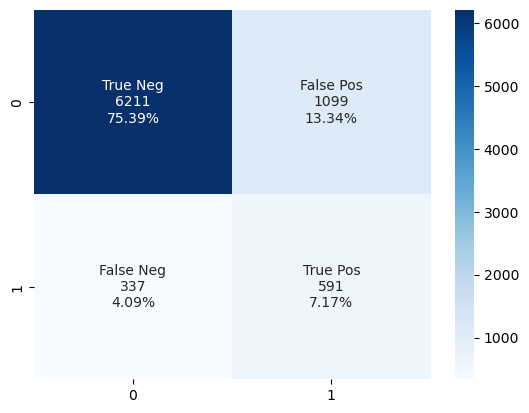

In [60]:
# Confusion matrix of test data

predicted_label_test = model.predict(X_test)
test_matrix_base = confusion_matrix(y_test, predicted_label_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in test_matrix_base.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in test_matrix_base.flatten()/np.sum(test_matrix_base)]
labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(test_matrix_base, annot = labels, fmt = '', cmap = 'Blues')

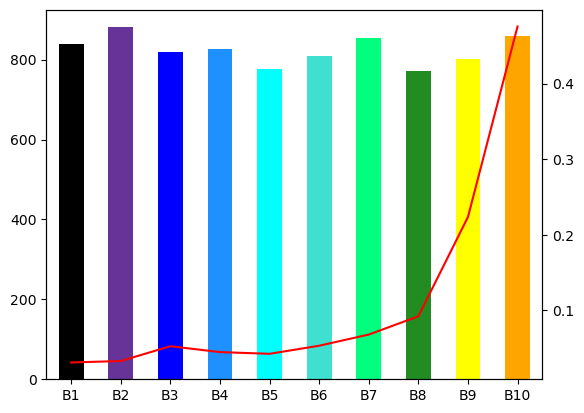

In [61]:
# Lift chart of test data

prediction_tb_test = pd.DataFrame(y_test, columns = ["successful_sell"])
prediction_tb_test["predicted_label"] = predicted_label_test
prediction_tb_test["predicted_proba"] = preds_test
prediction_tb_test["bucket"] = pd.cut(preds_test, threshold, labels =[1,2,3,4,5,6,7,8,9,10])

bucket_tb_test = prediction_tb_test.groupby('bucket', as_index = False)\
                    .agg(volume = ("successful_sell", "count"), sell_rate = ("successful_sell","mean"),
                         BucketMax = ("predicted_proba","max"), BucketMin = ("predicted_proba","min"))

colors=['black','rebeccapurple','blue','dodgerblue','cyan','turquoise','springgreen','forestgreen','yellow','orange']
bucket_tb_test['volume'].plot(kind='bar', color = colors)
bucket_tb_test['sell_rate'].plot(secondary_y=True, color = 'r')
ax = plt.gca()
ax.set_xticklabels(('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10'))
plt.show()

Train and test data yield similar result. There is negligible signs of overfitting.


### Model Explanability

We will use SHAP to explain the model. Using SHAP, we will look at the overall impact of the feature. Then we will also look at how each feature influence the individual predictions

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


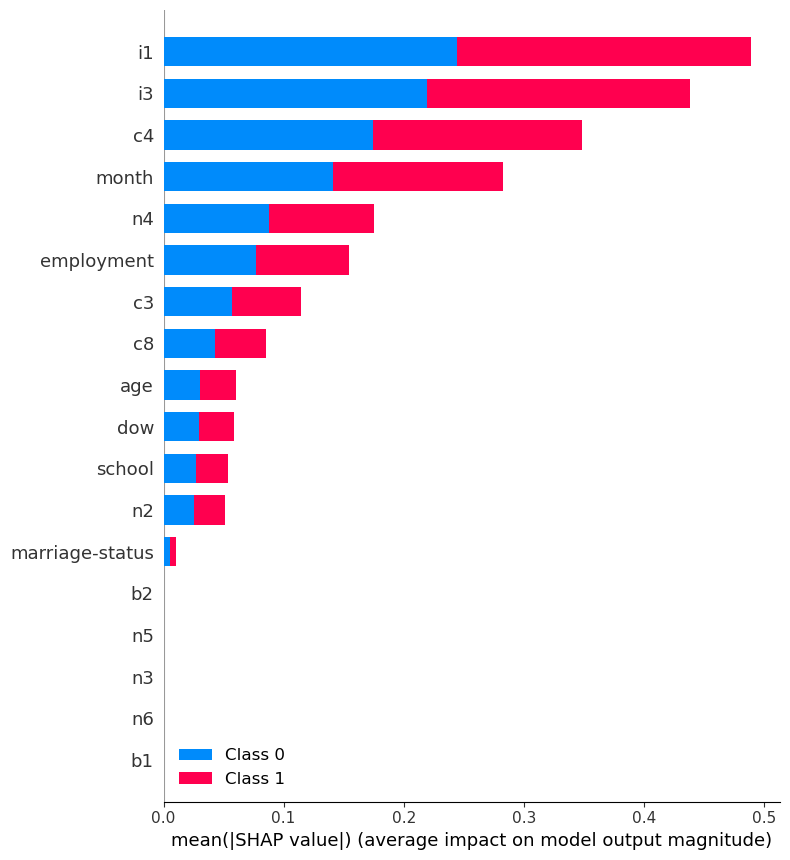

In [63]:
shap.summary_plot(shap_values, X_train)

In [64]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

# Deployment

### Document the Python environment

In [65]:
pip freeze

alembic==1.8.1
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644569878360/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
attrs @ file:///opt/conda/conda-bld/attrs_1642510447205/work
autopage==0.5.1
backcall @ file:///home/ktietz/src/ci/backcall_1611930011877/work
beautifulsoup4 @ file:///C:/ci/beautifulsoup4_1650274792587/work
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
Bottleneck @ file:///C:/Windows/Temp/abs_3198ca53-903d-42fd-87b4-03e6d03a8381yfwsuve8/croots/recipe/bottleneck_1657175565403/work
certifi @ file:///C:/b/abs_ac29jvt43w/croot/certifi_1665076682579/work/certifi
cffi @ file:///C:/Windows/Temp/abs_6808y9x40v/croots/recipe/cffi_1659598653989/work
cliff==4.0.0
cloudpickle==2.2.0
cmaes==0.8.2
cmd2==2.4.2
colorama @ file:///C:/Windows/TEMP/abs_9439aeb1-0254-449a-96f7-33ab5eb17fc8apleb4yn/croots/recipe/colorama_1657009099097/work
colorlog==6.7.0
cyc

### Pickle all relevant data

Pickle library of popular items

In [66]:
PopularItems_File = open('PopularItems', 'wb')
pickle.dump(lib_of_popular_items, PopularItems_File)
PopularItems_File.close()

Pickle the LGBM model

In [67]:
pickle.dump(model,open('LGBM_Model.sav', 'wb'))

Pickle boundaries of boxplot

In [68]:
BoundaryDict_File = open('Boundaries', 'wb')
pickle.dump(bound_dict,BoundaryDict_File)
BoundaryDict_File.close()

Pickle means and medians of numeric columns

In [69]:
CenterDict_File = open('Centers', 'wb')
pickle.dump(center_dict,CenterDict_File)
CenterDict_File.close()

Pickle label indexer

In [70]:
pickle.dump(indexer_lib,open('Encoder.sav', 'wb'))

Pickle threshold for bucketing the probabilities

In [71]:
threshold_File = open('Thresholds', 'wb')
pickle.dump(threshold,threshold_File)
threshold_File.close()


### Inferencing

Load all pickles

In [72]:
loaded_model = pickle.load(open('LGBM_Model.sav', 'rb'))
lib_of_popular_items2 = pickle.load(open('PopularItems', 'rb'))
bound_dict2 = pickle.load(open('Boundaries', 'rb'))
center_dict2 = pickle.load(open('Centers', 'rb'))
indexer_lib2 = pickle.load(open('Encoder.sav', 'rb'))
threshold2 = pickle.load(open('Thresholds', 'rb'))

Processing script

In [75]:

#read new data
new_data = pd.read_csv('C:\\Users\\17138\\Downloads\\phdata-ds-project-challenge\\project_data.csv')

#columns
num_cols = ['age','i1','i3','n2', 'n3','n5']
cat_cols = ['b1', 'b2', 'c3', 'c4', 'c8', 'dow', 'employment','marriage-status', 'month','n4','n6','school']
crowded_cols = ['n4','n6','school']

#select relevant columns from new data
new_data = new_data[num_cols + cat_cols]

#convert data type
for cat in cat_cols:
    new_data = new_data.astype({cat:str})
for num in num_cols:
    new_data = new_data.astype({num:float})
    
# Convert low frequency value into nulls using user defined function
new_data = nullify_rare_items(new_data, crowded_cols, lib_of_popular_items2)

# Fill null values in categorical values with new category 'Others'
new_data = fillna_with_label(new_data,cat_cols,'Others')

for i in num_cols:
    # fill nulls with median
    new_data[i] = new_data[i].fillna(center_dict2[i]['median'], inplace = False)
    # clip outliers with boundary values
    new_data[i] = new_data[i].clip(lower = bound_dict2[i]['lower_bound'], upper = bound_dict[i]['upper_bound'])

#Label encoding    
for f in cat_cols:
    new_data[f] = indexer_lib2[f].transform(new_data[f])

# Convert cat_cols to categorical type    
for col in cat_cols:
    new_data[col] = pd.Categorical(new_data[col])
    
# Prediction
#Probability
preds_newData = loaded_model.predict_proba(new_data)[:,1]
new_data['predicted_probability'] = preds_newData

#label
predicted_label_newData = loaded_model.predict(new_data[cat_cols+num_cols])
new_data['predicted_label'] = predicted_label_newData

#bucket
new_data["bucket"] = pd.cut(preds_newData, threshold2, labels =[1,2,3,4,5,6,7,8,9,10])